In [1]:
import pandas as pd
import numpy as np
from numpy import unique
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer,intercluster_distance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Reading Data
Data Preprocessing 

In [2]:
df=pd.read_csv('Mall_Customers.csv')

In [3]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [4]:
df.describe(include='all')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


In [5]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

# Data Visualization
Understanding data through visual aids

## Distribution Plot

<Figure size 1000x800 with 0 Axes>

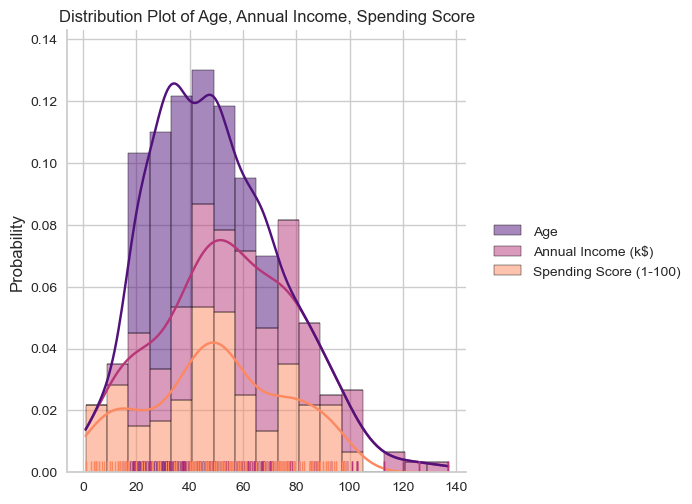

In [7]:
plt.figure(figsize=(10,8))
sns.displot(data=df[[ 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)']],multiple='stack',kde=True,palette='magma',rug=True,stat='probability')
plt.title('Distribution Plot of Age, Annual Income, Spending Score')
plt.show()

## Count Plot & Bar Plot
#### Understanding Categorical values

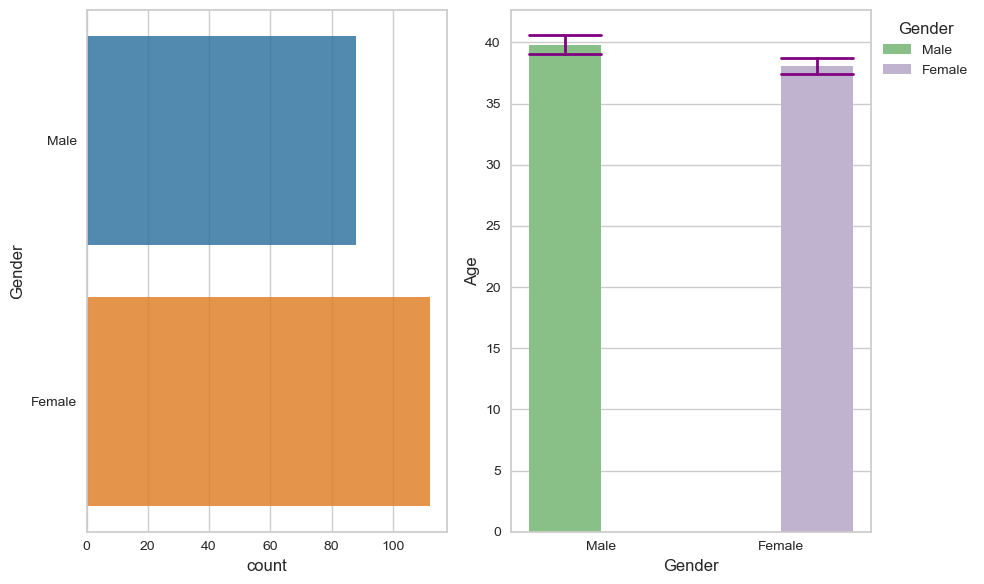

In [18]:
fig,axes = plt.subplots(1, 2,figsize=(10,6))
sns.countplot(y=df['Gender'],alpha=0.85,ax=axes[0],palette='tab10')
sns.barplot(data=df,y='Age',x='Gender',hue='Gender',errorbar=('ci',40),
            palette='Accent',errcolor="purple",errwidth=2,capsize=0.4,ax=axes[1])
sns.move_legend(axes[1], "upper left",bbox_to_anchor=(1, 1))
plt.show()

## Pair Plot
##### This Plot shows various relationships between Age, Annual Income and Spending Score

<Figure size 1500x900 with 0 Axes>

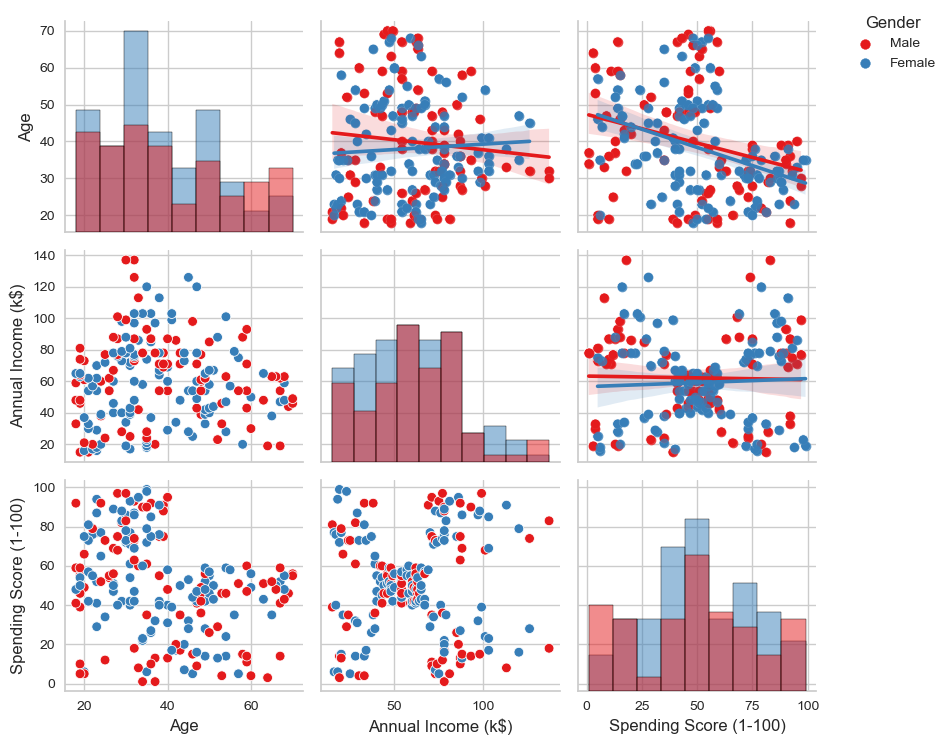

In [19]:
plt.figure(figsize=(15,9))
ax=sns.pairplot(data=df,vars=['Age','Annual Income (k$)','Spending Score (1-100)'],hue='Gender',
             palette='Set1',diag_kind='hist',kind='scatter')
ax.map_upper(sns.regplot)
sns.move_legend(ax, "upper left",bbox_to_anchor=(1, 1))
plt.show()
# diag_kws=dict(color='red',kde=True),plot_kws=dict(color='red')

## Heatmap 
##### Understanding Correlation between features

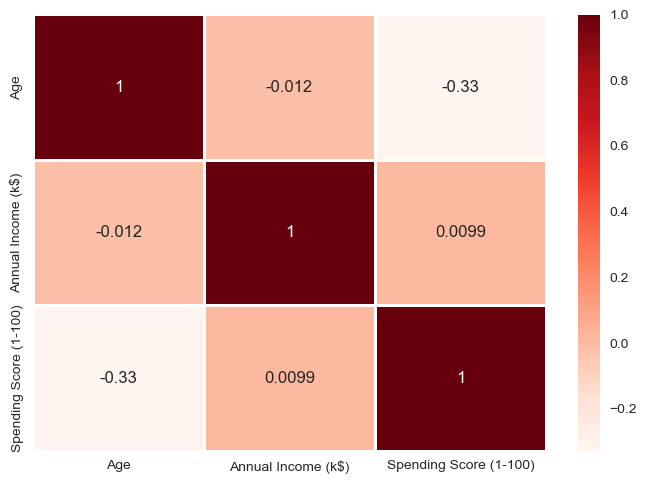

In [20]:
plt.figure(figsize=(7, 5))
df1=df[['Age','Annual Income (k$)','Spending Score (1-100)']]
sns.heatmap(df1.corr(), annot=True,linewidth=.8, cmap="Reds");

##### There is no definite relationships between these 3 feature groups, moreover Age has negative correlation with other features. 

## Scatter Plots

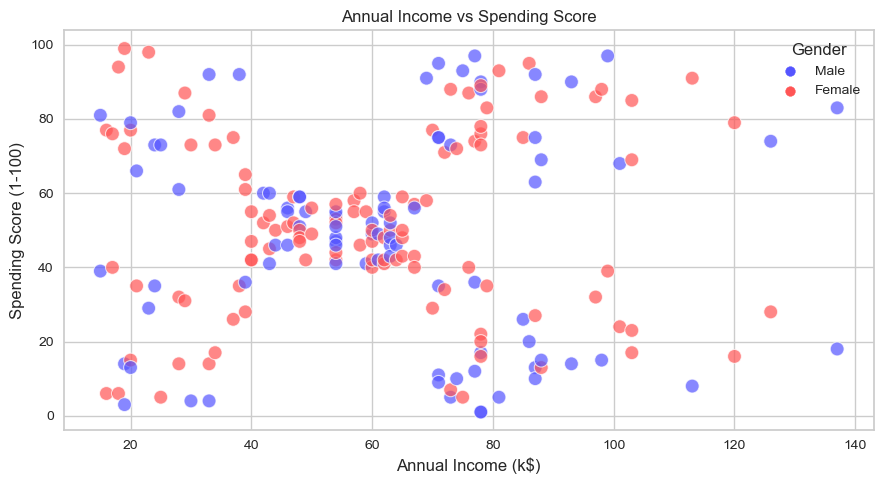

In [21]:
plt.figure(figsize=(9,5))
sns.scatterplot(df,x='Annual Income (k$)',y='Spending Score (1-100)',hue='Gender',palette='seismic',s=100,alpha=0.7)
plt.title('Annual Income vs Spending Score')
plt.show()

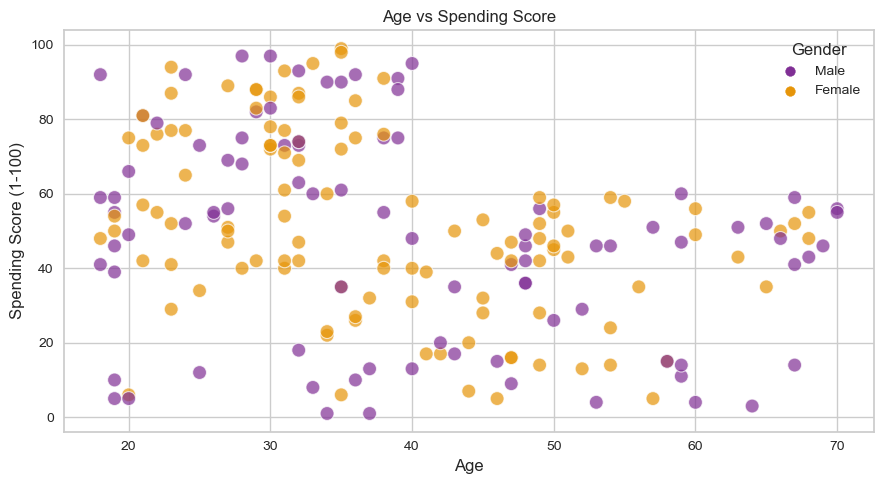

In [22]:
plt.figure(figsize=(9,5))
sns.scatterplot(df,x='Age',y='Spending Score (1-100)',hue='Gender',palette='CMRmap',s=100,alpha=0.7)

plt.title('Age vs Spending Score')
plt.show()

# Clustering
###### Feature Selection

In [76]:
X1=df[['Age','Annual Income (k$)','Spending Score (1-100)']]
# X2=StandardScaler().fit_transform(df[['Age','Annual Income (k$)','Spending Score (1-100)']])

## 1. KMeans 

##### Selecting best 'k' value using Elbow method

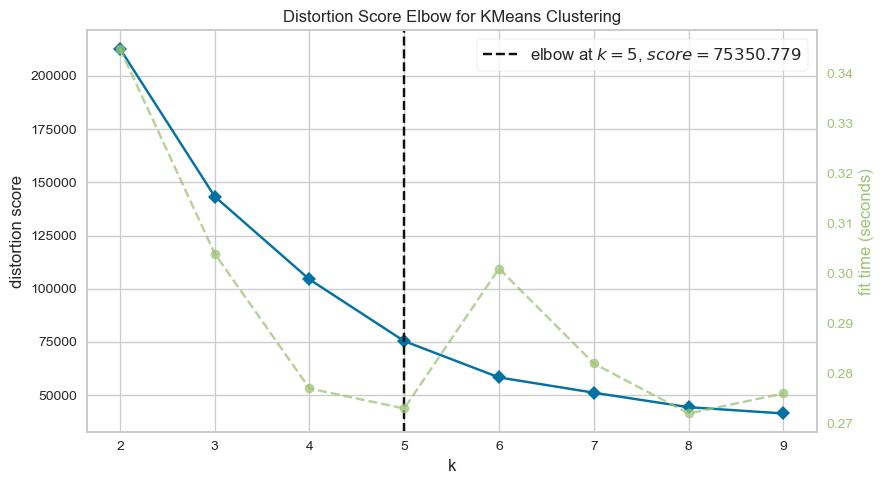

In [64]:
visualizer = KElbowVisualizer(KMeans(),k=(2,10))
visualizer.fit(X1) 
visualizer.poof()
plt.show()

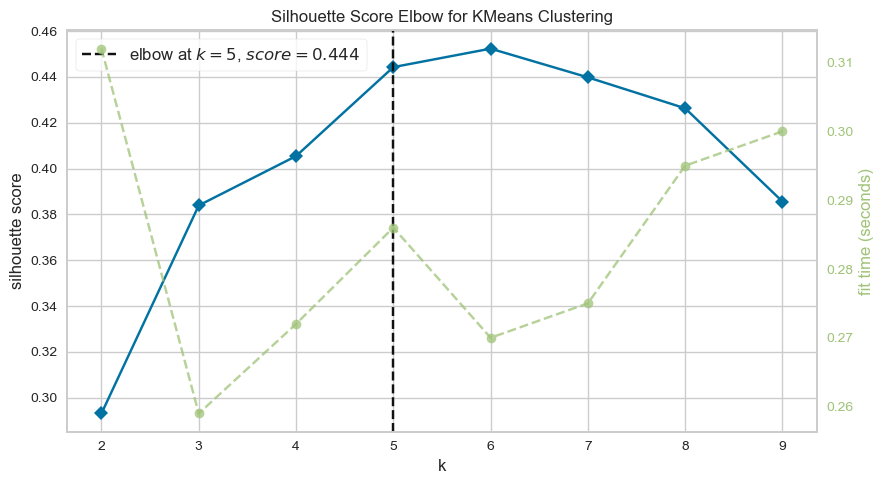

In [63]:
visualizer = KElbowVisualizer(KMeans(random_state=23),k=(2,10),metric='silhouette')
visualizer.fit(X1) 
visualizer.show()
plt.show()

We obtain ideal K value as 5 from the above methods.
We now check its average Silhouette Score for K=5

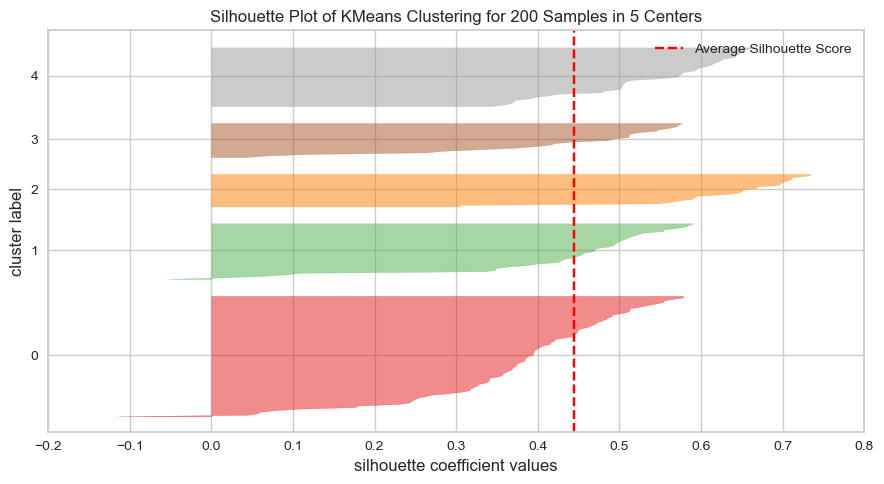

In [26]:
sil_visualizer = SilhouetteVisualizer(KMeans(5))
sil_visualizer.fit(X1)
sil_visualizer.show()
plt.show()

Now we check for a non ideal K value, let K=4

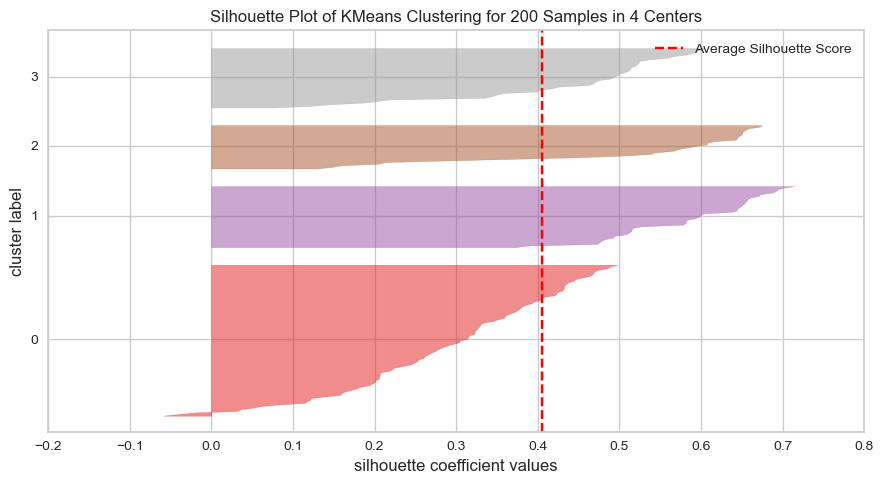

In [28]:
sil_visualizer = SilhouetteVisualizer(KMeans(4))
sil_visualizer.fit(X1)
sil_visualizer.show()
plt.show()

We observe that there in decrease in Average Silhouette Score value when K=4 which is non ideal.
Thus we will train our model with K=5

In [29]:
#Now we know that optimal k value is 5
k=5
K_means=KMeans(init="k-means++",n_clusters=k)
K_means.fit(X1)

KMeans(n_clusters=5)

In [30]:
df['KM_Cluster']=K_means.labels_

In [31]:
KM_centres=K_means.cluster_centers_

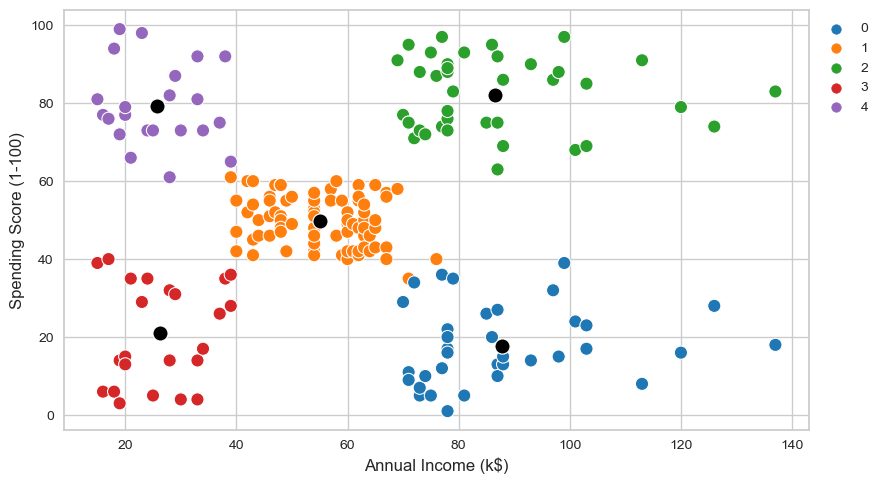

In [32]:
plt.figure(figsize=(9,5))
ax=sns.scatterplot(data=df,x='Annual Income (k$)', y='Spending Score (1-100)',hue='KM_Cluster',palette='tab10',s=90)
ax=sns.scatterplot(x=KM_centres[:,1],y=KM_centres[:,2],s=120,color='black')
sns.move_legend(ax, "upper left",bbox_to_anchor=(1, 1))
plt.show()

We obtain well segmented clusters for the features: Annual Income vs Spending Score

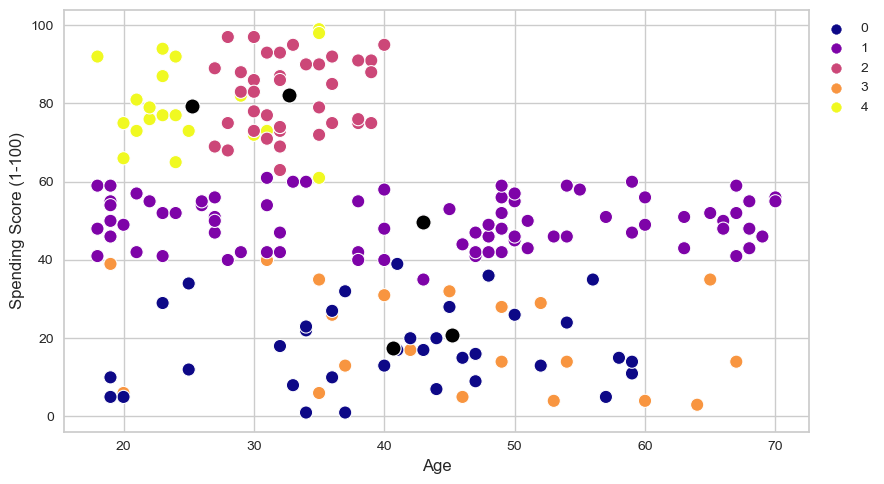

In [37]:
plt.figure(figsize=(9,5))
ax=sns.scatterplot(data=df,x='Age', y='Spending Score (1-100)',hue='KM_Cluster',palette='plasma',s=90)
ax=sns.scatterplot(x=KM_centres[:,0],y=KM_centres[:,2],s=120,color='black')
sns.move_legend(ax, "upper left",bbox_to_anchor=(1, 1))
plt.show()

## 2. Heirarchical Clustering

###### Creating Dendogram to obtain required cluster count

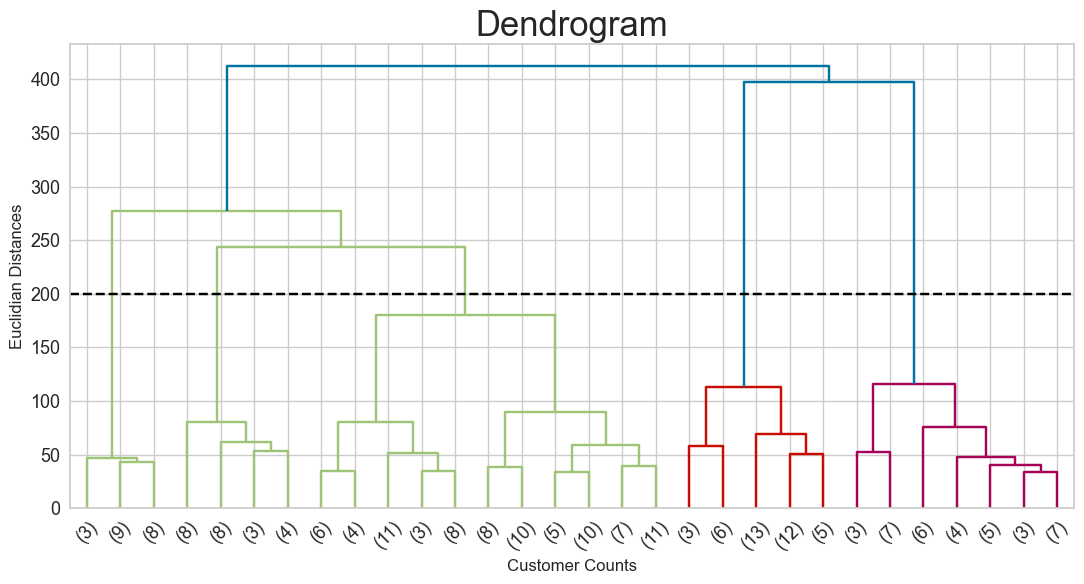

In [41]:
plt.figure(figsize=(11, 6))
dendo = dendrogram(linkage(X1, method='ward'),leaf_font_size=5,truncate_mode = 'lastp') 
plt.axhline(y=200 , color='black',linestyle = '--')
plt.title('Dendrogram', fontsize=25) 
plt.xlabel('Customer Counts')
plt.ylabel('Euclidian Distances')
plt.yticks(fontsize=13)  
plt.xticks(fontsize=13) 
plt.show() 

In [42]:
agc = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agc.fit(X1)
df['HC_Cluster']=agc.labels_

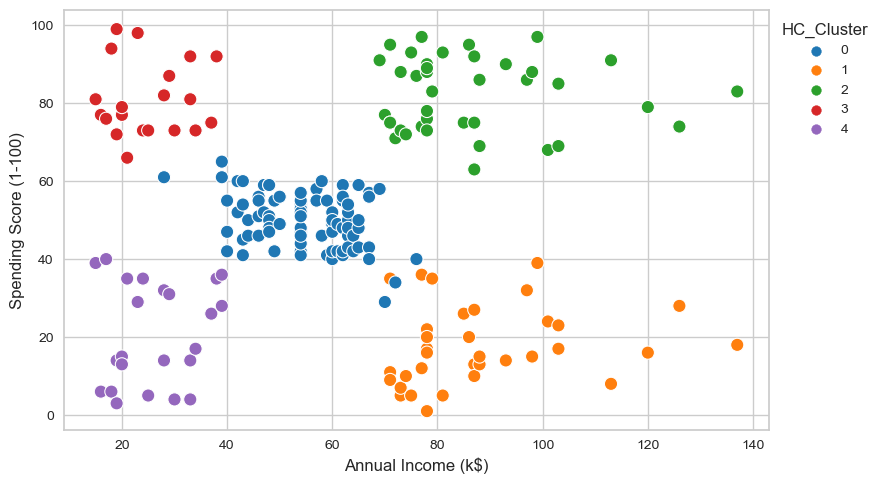

In [43]:
plt.figure(figsize=(9,5))
ax=sns.scatterplot(data=df,x='Annual Income (k$)', y='Spending Score (1-100)',hue='HC_Cluster',palette='tab10',s=90)
sns.move_legend(ax, "upper left",bbox_to_anchor=(1, 1))
plt.show()

## 3. DBSCAN

##### Determining suitable eps and min_sample values

In [44]:
db = DBSCAN(eps=10,min_samples=6) #arbitrary eps and min_sample values
db.fit(X1) 
tlabels = db.labels_
tlabels

array([-1,  0, -1,  0, -1,  0, -1, -1, -1,  0, -1, -1, -1,  0, -1,  0, -1,
        0, -1, -1, -1,  0, -1,  0, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2,
       -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,
        2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1,  2, -1, -1,
       -1,  2, -1,  2, -1,  2, -1, -1, -1,  2, -1,  2, -1,  2, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

We obtain a large amount of -1 values which corresponds to Outliers.
Thus we need to adjust eps and min_sample values such that we obtain more Cluster labels than Outliers.

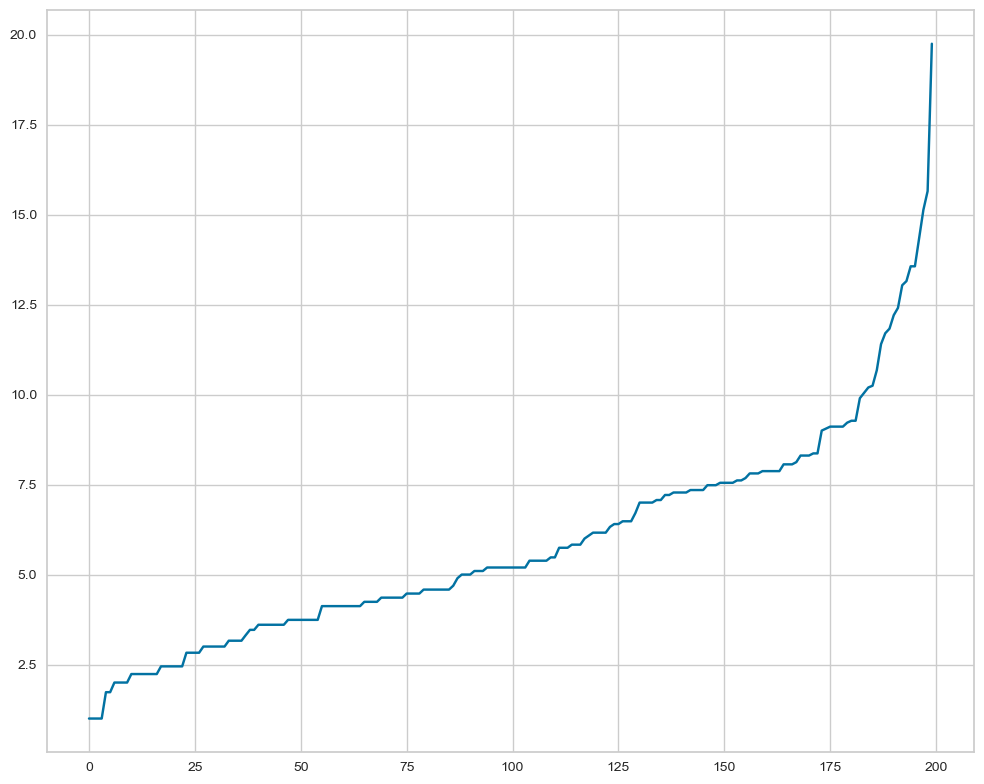

In [77]:
ep,count = NearestNeighbors(n_neighbors=20).fit(X1).kneighbors(X1) #arbitrary n_neighbors value
ep = np.sort(ep, axis=0)
plt.figure(figsize=(10,8))
plt.plot(ep[:,1])
plt.show()

The curve gradually increases for an epsilon (eps) value of 9, covering more than 87% of our data samples.
Subsequently, the curve becomes more stagnant. As a result, we will examine the epsilon (eps) value upto 13.

In [79]:
min_samples = range(2,10)
eps = np.arange(9,13, 0.25)
output = []
for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(eps = ep,min_samples=ms).fit(X1).labels_
        score = metrics.silhouette_score(X1, labels)
        output.append((ms, ep, score))
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")        

Best silhouette_score: 0.2555628510249617
min_samples: 4
eps: 12.5


In [80]:
db = DBSCAN(eps=12.5,min_samples=4)
db.fit(X1) 
labels = db.labels_
df['DB_Cluster']=labels
labels

array([ 0,  0, -1,  0,  0,  0, -1, -1,  1,  0, -1, -1,  1,  0, -1,  0,  0,
        0,  0, -1,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  1,  0,  1,  0,
        1,  0,  1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  2,  0,  2,  0,  2,  3,  2,  3,  2,  0,  2,  4,  2,
        3,  2,  4,  2,  3,  2,  0,  2,  4,  2,  0,  2,  3,  2,  3,  2,  3,
        2,  3,  2,  3,  2, -1,  2,  3,  2,  4,  2,  3,  2,  3,  2,  3,  2,
        3,  2,  3,  2,  3,  2,  3,  2,  3,  2,  3,  2,  3,  2,  3,  2,  3,
       -1,  3,  2,  3, -1, -1,  2, -1, -1, -1, -1, -1, -1], dtype=int64)

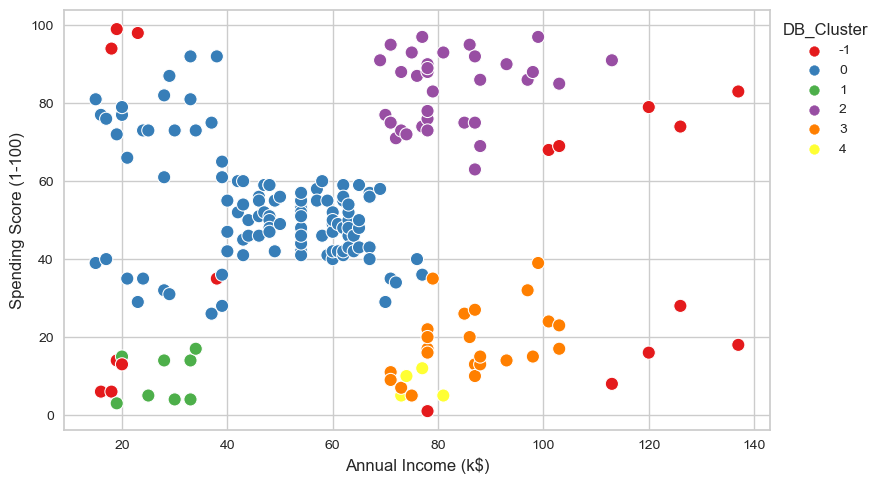

In [53]:
plt.figure(figsize=(9,5))
ax=sns.scatterplot(data=df,x='Annual Income (k$)', y='Spending Score (1-100)',hue='DB_Cluster',palette='Set1',s=90)
# ax=sns.scatterplot(x=centres[:,0],y=centres[:,2],s=120,color='black')
sns.move_legend(ax, "upper left",bbox_to_anchor=(1, 1))
plt.show()

##### Red points indicate Outliers

In [75]:
# plt.figure(figsize=(9,5))
# ax=sns.scatterplot(data=df,x='Age', y='Spending Score (1-100)',hue='DB_Cluster',palette='Set1',s=90)
# # ax=sns.scatterplot(x=centres[:,0],y=centres[:,2],s=120,color='black')
# sns.move_legend(ax, "upper left",bbox_to_anchor=(1, 1))
# plt.show()

# 4. Mean Shift

Selecting optimal Bandwidth(radius) value using estimate_bandwidth() funtion

In [54]:
estimate_bandwidth(X1, quantile=0.1)

22.173844534734847

In [55]:
mean_shift = MeanShift(bandwidth=22.173844534734847)
mean_shift.fit(X1)

MeanShift(bandwidth=22.173844534734847)

In [56]:
yhat_ms = mean_shift.predict(X1)
clusters_ms = unique(yhat_ms)
print("Clusters of Mean Shift:", clusters_ms)

Clusters of Mean Shift: [0 1 2 3 4]


In [81]:
labels_ms =mean_shift.labels_ 
df['MS_Cluster']=labels_ms
centroids_ms = mean_shift.cluster_centers_

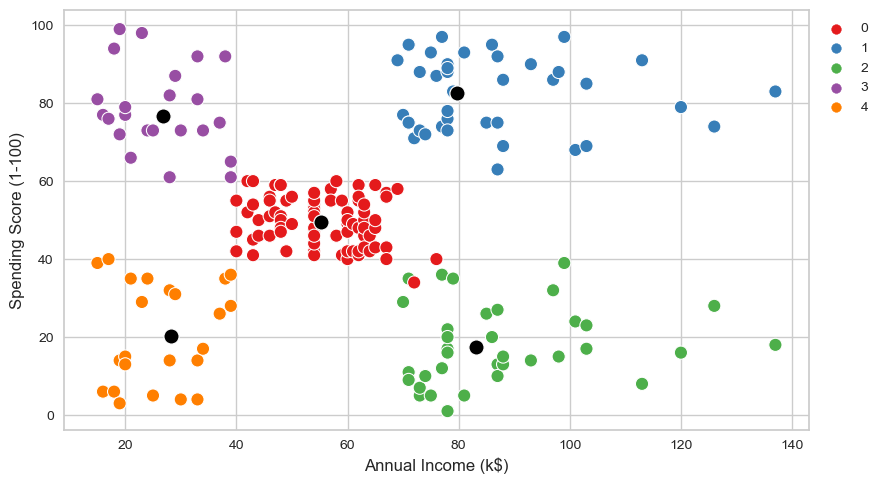

In [59]:
plt.figure(figsize=(9,5))
ax=sns.scatterplot(data=df,x='Annual Income (k$)', y='Spending Score (1-100)',hue='MS_Cluster',palette='Set1',s=90)
ax=sns.scatterplot(x=centroids_ms[:,1],y=centroids_ms[:,2],s=120,color='black')
sns.move_legend(ax, "upper left",bbox_to_anchor=(1, 1))
plt.show()

### Model Evaluation metrics

##### CLUSTER VALIDATION
Cluster validation is the process of assessing
how well a clustering algorithm produces its
results. It is crucial to keep this in mind
while contrasting two clustering methods or
making sure that any patterns found in the
data are not insignificant.

1. SILHOUETTE VALUE:
The Silhouette value is a measure that
evaluates a cluster object's closeness with
its own cluster as contrasted to other
clusters. A strong silhouette value suggests
that an object is well suited to its own
cluster and not well suited to its adjacent
groups. The silhouette value ranges
between -1 and +1, with a value of +1
indicating the best fit and a value of -1
indicating the worst match

2. DAVIES-BOULDIN SCORE:
The ratio of inter cluster distances to intra
cluster distances is referred to as Davies-
Bouldin score, which is the average
similarity measure between each cluster
and its most comparable cluster. It may be
calculated quite easily and is bounded from
0 to 1. A lower score indicates better cluster
validation

In [60]:
silhoutte_scores=[metrics.silhouette_score(X1,K_means.labels_),metrics.silhouette_score(X1,agc.labels_),
                  metrics.silhouette_score(X1,db.labels_),metrics.silhouette_score(X1,mean_shift.labels_)]

davies_bouldin_scores=[metrics.davies_bouldin_score(X1,K_means.labels_),metrics.davies_bouldin_score(X1,agc.labels_),
                  metrics.davies_bouldin_score(X1,db.labels_),metrics.davies_bouldin_score(X1,mean_shift.labels_)]

In [61]:
score_df={'Algorithm':["K-means", "Heirarchical", "DBSCAN", "Mean-Shift"],'Silhouette Score':silhoutte_scores,
          'Davies-Bouldin Scores':davies_bouldin_scores}
score_df=pd.DataFrame.from_dict(score_df)
score_df

,Algorithm,Silhouette Score,Davies-Bouldin Scores
0,K-means,0.445043,0.818801
1,Heirarchical,0.440189,0.821672
2,DBSCAN,0.255563,2.236800
3,Mean-Shift,0.443280,0.824391


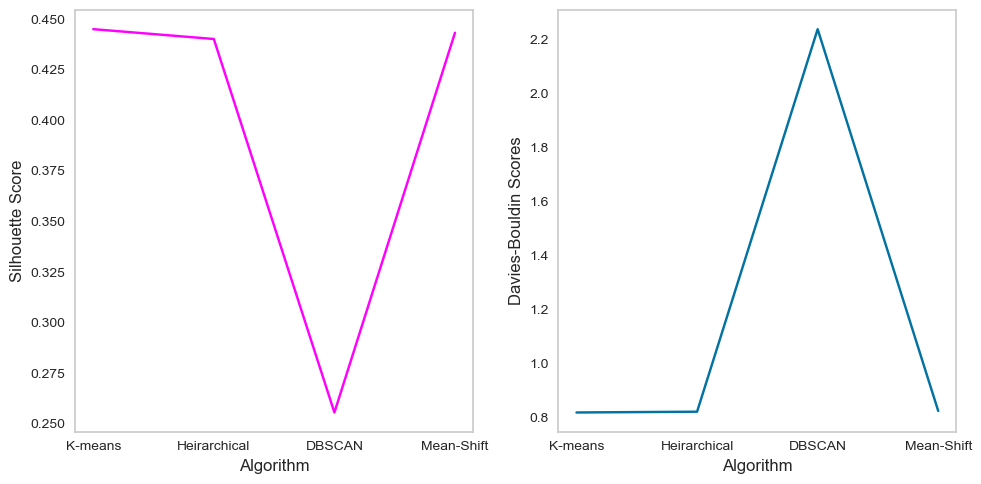

In [82]:
fig,axes = plt.subplots(1, 2, figsize=(10,5))
sns.lineplot(data=score_df,x='Algorithm',y='Silhouette Score',color='Magenta',ax=axes[0])
sns.lineplot(data=score_df,x='Algorithm',y='Davies-Bouldin Scores',ax=axes[1])
axes[0].grid()
axes[1].grid()
plt.show()

### Conclusions
The comparative analysis of above
clustering techniques gives us a thorough
result which tells us which of the techniques
are more efficient and should be
implemented by different organizations for
their respective customers.

1. After doing the analysis we found that the scores of KMeans and Mean-Shift are nearly close. We take the Silhouette Score as a priority over Davies-Bouldin value The reason for this is that the Silhouette score calculates the Euclidean distance based on the nearness of centroids and also takes into accounts other factors such as variance, skewness, high-low differences,etc., whereas the Davies-Bouldin value is calculated as the ratio between its interclusters and intra-clusters only, thus based on these factors we see that the Silhouette scores accuracy tends to be slightly better than the Davies-Bouldin value thus KMeans remains on top here for a better approach to Clustering algorithms for Customer Segmentation.


2. We see other algorithms too, but their Silhouette and Davies-Bouldin score have a much greater difference in respect to KMeans and Mean-shift thus they remain lower in the table. Thus, the correct order of Clustering
Algorithms would be: 
    1. KMeans
    2. Mean-Shift
    3. Hierarchical
    4. DBSCAN

Thus, the inference drawn is that KMeans is the better approach to Clustering Algorithms for Customer Segmentation among the four algorithms that we have selected.